# Forecasting Passenger Survival

##### This project was taken from kaggle to predict the passengers that survived the sinking of the Titanic or not. It is to be delt with a binary classification problem (0 = Survived and 1 = did not Survived)

##### The Dataset is split in two groups, training set and test set. These sets contain Titanuc passengers information, but only the training set indicates for each present passengers if they survived or not the titanic sinking.

###### Variables in this dataset are the following:
survival; pclass; sex; age; sibsp; parch; ticket; fare; cabin; embarked

##### The variables in this dataset are the following:

##### Notes about the variables:
- Survived => 0 = No, 1 = Yes;
- pclass => 1 = 1st, 2 = 2nd, 3 = 3rd ==> Represents the class;
- sex => male or female ==> Represents the sex of the passenger;
- Age => It is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- SibSp => Defines family relations the way showned below:
    - Sibling => brother, sister, stepbrother, stepsister
    - Spouse => husband, wife(mistresses and fiancés are ignored)
- Parch => Defines family relations the way showned below:
    - Parent => mother, father
    - Child => daughter, son, stepdaughter, stepson
    - Note: Some children travelled only with a nanny, therefore parch=0 for them

In [41]:
import sys

# Exploratory Data Analysis + Plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# OriginalEncoder will give a unique ID for some columns and OneHotEncoder (categorical features) to make a unique from a choosen column
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# help with missing data
from sklearn.impute import SimpleImputer

# To construc a column transformer from the given transformers.
from sklearn.compose import make_column_transformer
# Apply the list of transformers to preprocess the data
from sklearn.pipeline import Pipeline, make_pipeline

# just a process of modeling the probality of a discrete oucome given an input variable (binary outcome, 0 and 1)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Check the data in the files

In [18]:
# Normal 'first step' to make to check thedata in the file.
# PassengerId does not look important.
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [40]:
# We need to check with what type of data we will work with;
# Since there are 'objet' dtypes, ML can not handle those ones, they should be fixed
# Cabin column has a huge amout of 'NaN' rows.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [46]:
# Checking the amount of missing values in the training set.
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Family_Size      0
dtype: int64

In [48]:
# Checking on those 2 unknown Embarked null values.
train_df[train_df['Embarked'].isnull()]

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  Family_Size  
61   female  38.0      0      0  113572  80.0   B28      NaN            1  
829  female  62.0      0      0  113572  80.0   B28      NaN            1

##### From here we an be confident the passengers know each other, as they have share the same ticket number. For that I will check the number of ocurrences for each element in Embarked filtering the data by PClass (First Class) and Sex (Female).

In [50]:
train_df.groupby(['Pclass', 'Sex'])['Embarked'].value_counts()

Pclass  Sex     Embarked
1       female  S            48
                C            43
                Q             1
        male    S            79
                C            42
                Q             1
2       female  S            67
                C             7
                Q             2
        male    S            97
                C            10
                Q             1
3       female  S            88
                Q            33
                C            23
        male    S           265
                C            43
                Q            39
Name: count, dtype: int64

##### Filtering like intended, a female passenger on upper class, embarked or from 'S' (Southamton) or from 'C' (Cherbourg). Since we are dealing with only 2 missing values from this variable, I will fill them with the value 'S'.

In [51]:
# Filling the missing values from Embarked variable
train_df['Embarked'] = train_df['Embarked'].fillna('S')

#### I will then continue exploring the data.

In [22]:
# Some more infos, with max, min, mean, etc... numerical.
train_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [21]:
# Check unnique values for the objects dtypes.
train_df.describe(include=['O'])

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

### Check the survival average...

In [35]:
# Check the average of people who survived considering the class 
train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

In [34]:
# Check the average of people who survived considering their sex
train_df.groupby(['Sex'], as_index=False)['Survived'].mean()

Sex  Survived
0  female  0.742038
1    male  0.188908

In [36]:
# Check the average of people who survived conseidering number of siblings/spouses on board
train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()

SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000

In [38]:
# Check the average of people who survived conseidering number of parents/siblings on board
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000

In [43]:
# Make a column for the family size with sum of SibSp (number of siblings/spouses) + Parch(Parents/child) + 1 (for the person itself)
# Each step done with train will be done with test
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [47]:
# Check the average of survavibility by family size
train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()

Family_Size  Survived
0            1  0.303538
1            2  0.552795
2            3  0.578431
3            4  0.724138
4            5  0.200000
5            6  0.136364
6            7  0.333333
7            8  0.000000
8           11  0.000000

In [54]:
# And the average from the Embarked door
train_df.groupby(['Embarked'], as_index=False)['Survived'].mean()

Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009

#### Some graphs to help visualize the data

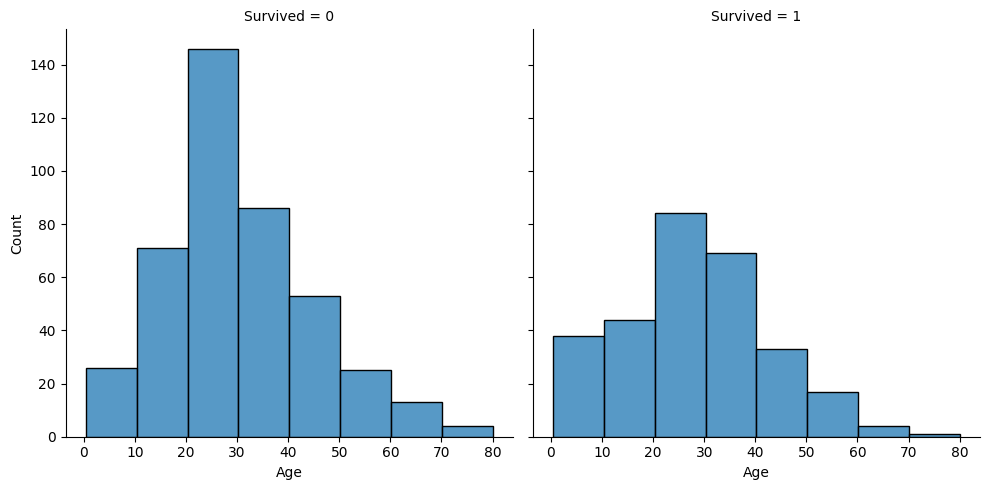

In [60]:
# Checking visualy by Age the passengers who survived or didn't survived. 
sns.displot(train_df, x='Age', col='Survived', binwidth=10)

In [62]:
# In here I quarter cutted (age range) by age and survival rate.
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 8)
test_df['Age_Cut'] = pd.qcut(test_df['Age'], 8)

In [64]:
train_df.groupby(['Age_Cut'], as_index=False, observed=False)['Survived'].mean()

Age_Cut  Survived
0   (0.419, 16.0]  0.550000
1  (16.0, 20.125]  0.341772
2  (20.125, 24.0]  0.367347
3    (24.0, 28.0]  0.352941
4  (28.0, 32.312]  0.416667
5  (32.312, 38.0]  0.450549
6    (38.0, 47.0]  0.329545
7    (47.0, 80.0]  0.415730

In [70]:
# In here I will LOC by age range.
train_df.loc[train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 20.125), 'Age'] = 1
train_df.loc[(train_df['Age'] > 20.125) & (train_df['Age'] <= 24), 'Age'] = 2
train_df.loc[(train_df['Age'] > 24) & (train_df['Age'] <= 28), 'Age'] = 3
train_df.loc[(train_df['Age'] > 28) & (train_df['Age'] <= 32.312), 'Age'] = 4
train_df.loc[(train_df['Age'] > 32.312) & (train_df['Age'] <= 38), 'Age'] = 5
train_df.loc[(train_df['Age'] > 38) & (train_df['Age'] <= 47,0), 'Age'] = 6
train_df.loc[(train_df['Age'] > 47) & (train_df['Age'] <= 80), 'Age'] = 7
train_df.loc[train_df['Age'] > 80]

test_df.loc[test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 20.125), 'Age'] = 1
test_df.loc[(test_df['Age'] > 20.125) & (test_df['Age'] <= 24), 'Age'] = 2
test_df.loc[(test_df['Age'] > 24) & (test_df['Age'] <= 28), 'Age'] = 3
test_df.loc[(test_df['Age'] > 28) & (test_df['Age'] <= 32.312), 'Age'] = 4
test_df.loc[(test_df['Age'] > 32.312) & (test_df['Age'] <= 38), 'Age'] = 5
test_df.loc[(test_df['Age'] > 38) & (test_df['Age'] <= 47,0), 'Age'] = 6
test_df.loc[(test_df['Age'] > 47) & (test_df['Age'] <= 80), 'Age'] = 7
test_df.loc[test_df['Age'] > 80]

C:\Users\PascualFelicio\AppData\Local\Temp\ipykernel_12268\2850556762.py:8: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  train_df.loc[(train_df['Age'] > 38) & (train_df['Age'] <= 47,0), 'Age'] = 6


ValueError: setting an array element with a sequence.